## Machine Learning
After looking at the data in the previous steps, I decided to group the hurricane impacts per year into groups based on the number of hurricanes per year and the average category strength per year.

There is one main predictions that will be made:
1. The number of hurricanes severity for that year.
2. The average strength severity for that year.

**For lack of time I only did one prediction group (number of hurricanes for the year).  There is code written for two groups up until a point, then I notated where future work could be done.**

In [1]:
#load the necessary datasets and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

hurricanes_df = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 1/hurricanes_df.csv", 
                            index_col = 0, parse_dates=True)

wod_df_date = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 1/wod_df_date.csv", 
                          index_col = 0, parse_dates=True)

In [2]:
#have a look at the value counts for number of hurricanes per year occurrences
hurr_year = hurricanes_df.resample('A').count()
hurr_year = hurr_year[hurr_year.index.year <= 2012]
print('The value counts for the hurricanes per year data.')
print(hurr_year.name.value_counts().sort_index())
print()

#calculate average strength of hurricanes per year
cat_year = hurricanes_df.resample('A').mean().fillna(0)
cat_year = cat_year[cat_year.index.year <= 2012]
strengths = pd.Series([arr[0] for arr in cat_year.values], index = cat_year.index)
print('The value counts for the average strength per year data.')
print(strengths.value_counts().sort_index())

The value counts for the hurricanes per year data.
0     17
1     17
2     10
3      4
4      1
5      2
6      1
11     1
Name: name, dtype: int64

The value counts for the average strength per year data.
0.000000    17
1.000000    13
1.500000     2
1.666667     2
2.000000     6
2.166667     1
2.250000     1
2.500000     1
3.000000     7
3.666667     1
4.000000     2
dtype: int64


### After looking into the hurricane groupings, here are the categories for the groupings.


I chose to do groups intstead of linear regression techniques because I have strong suspicions that the model will always perform poorly if trying to predict the exact number of hurricanes per year or exact average strength per year.  Groups will allow for classification which I believe the model will have more success performing.  The impact is still similar in that we can still obtain quality information about the severity of the upcoming hurricane season.

Moreover, the scoring criterion for the models will be the classification report which includes precision, recall, and f1 scores for each class and an average for the scores.  Emphasis will be put on the f1_score as this score is best indicative in this case for a better model as I don't want too many false positives, and I also don't want too many false negatives.


1. Hurricanes per year:
    * No Impacts (0)
        * 0 hurricanes
    * Moderate (1)
        * 1-2 hurricanes
    * Severe (2)
        * 3+ hurricanes
2. Average strength per year:
    * Mild (0)
        * 0-1.5 average category ranking
    * Moderate (1)
        * 1.5-3 average category ranking
    * Severe (2)
        * 3-5 average category ranking
        
        
### Feature Engineering and Model Selection
1. Features
    * Since temperature was the only statistically significant trend, let's try just temperature as a feature first.
    * Try adding in the rest of the wod features into the model next.
        * The features will be averages for the time before the hurricane season (January 1st to May 31st) for that year.
    * Try adding in previous years ocean data as features.
        * The features will be averages for the time before the hurricane season (January 1st to May 31st) for the previous year.
    * Try adding in previous years number of hurricanes and average strength as features.
2. Models
    * Logistic Regression
    * SVM Classification
    * kNN
    
### Getting the features ready
#### Ocean data only
* We need to first get the world ocean database to be in the form of one observation per row with columns being the different features.

In [3]:
#fix up the wod df to be the feature set.
wod_yr = wod_df_date.loc[wod_df_date.index.month < 6].resample('A').mean()
X = np.array(wod_yr.reset_index(drop=True))

#create group labels for each case for number of hurricanes
y_hurr = np.empty(len(wod_yr.index))
for i, index in enumerate(wod_yr.index):
    if hurr_year.name[index] == 0:
        y_hurr[i] = int(0)
    elif (hurr_year.name[index]>=1) & (hurr_year.name[index]<=2):
        y_hurr[i] = int(1)
    elif hurr_year.name[index]>=3:
        y_hurr[i] = int(2)
        
#create group labels for each case for average strength of hurricanes
y_strength = np.empty(len(wod_yr.index))
for i, index in enumerate(wod_yr.index):
    if strengths[index] <= 1.5:
        y_strength[i] = 0
    elif (strengths[index]>1.5) & (strengths[index]<=3):
        y_strength[i] = 1
    else:
        y_strength[i] = 2

### 1. Logistic Regression
* ### A. Number of Hurricanes with just Temperature

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


def clf_mod_test(pipeline, data, target, params, split_test_size=.3, rand_iters=10, cv_folds=3, class_labels=[]):
    """Takes a pipeline, data, targets, CV search params, test_size, 
    number of iters and number of folds for RandomizedSearchCV, and the labels of classes.
    
    Returns a tuned and fitted model and f1 weighted score and prints a classification report and f1 score."""
    
    #split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = split_test_size)

    #run grid search on pipeline
    gm_cv = RandomizedSearchCV(pipeline, param_distributions = params, cv=cv_folds, n_iter=rand_iters)
    gm_cv.fit(X_train, y_train)
    C = gm_cv.best_params_['logistic_regression__C']
    print('The best C value is {}, with an accuracy of {}.'.format(gm_cv.best_params_['logistic_regression__C'], gm_cv.best_score_))
    print()

    #test model on test dataset and get classification report.
    y_pred = gm_cv.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_labels))
    print()
    
    #get f1 score for model comparison
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('The f1 score is : {}'.format(f1))
    
    return gm_cv, f1, C

#set up pipeline
steps = [('scaler', StandardScaler())
        ,('logistic_regression', LogisticRegression())]

pipeline_lr = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_lr = {'logistic_regression__C':np.arange(0.01,100000,.01)}
hurr_labels=['no impact', 'moderate', 'severe']


f1_hurr_temp = np.empty(5) 
C_hurr_temp = np.empty(5)
coeff_no = []
coeff_mild = []
coeff_sev = []
for i in range(5):
    lr_hurr_temp, f1_hurr_temp[i], C_hurr_temp[i] = clf_mod_test(pipeline = pipeline_lr, data=X[:,4].reshape(-1,1), 
                                                       target=y_hurr, params=params_lr, 
                                                       rand_iters=100, class_labels=hurr_labels, 
                                                       split_test_size=.3, cv_folds=3)
    coeffs = lr_hurr_temp.best_estimator_.named_steps['logistic_regression'].coef_
    print('The model coefficients are no impact:{}, moderate:{}, severe:{}.'.format(coeffs[0],coeffs[1],coeffs[2]))
    print()
    coeff_no.append(coeffs[0][0])
    coeff_mild.append(coeffs[1][0])
    coeff_sev.append(coeffs[2][0])
    
print('avg f1 is {}, avg C is {}, avg coeffs are no impact {}, mild {}, severe {}.'
      .format(np.mean(f1_hurr_temp), np.mean(C_hurr_temp), np.mean(coeff_no), np.mean(coeff_mild), np.mean(coeff_sev)))

The best C value is 61748.96000000001, with an accuracy of 0.5405405405405406.

             precision    recall  f1-score   support

  no impact       0.50      0.17      0.25         6
   moderate       0.57      0.89      0.70         9
     severe       0.00      0.00      0.00         1

avg / total       0.51      0.56      0.49        16


The f1 score is : 0.4850543478260869
The model coefficients are no impact:[ 0.73830626], moderate:[-0.13275419], severe:[-0.67934749].



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best C value is 1226.53, with an accuracy of 0.5405405405405406.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         6
   moderate       0.44      1.00      0.61         7
     severe       0.00      0.00      0.00         3

avg / total       0.19      0.44      0.27        16


The f1 score is : 0.266304347826087
The model coefficients are no impact:[ 0.41896627], moderate:[-0.02561462], severe:[-0.62048975].



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best C value is 62019.5, with an accuracy of 0.5405405405405406.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         7
   moderate       0.44      1.00      0.61         7
     severe       0.00      0.00      0.00         2

avg / total       0.19      0.44      0.27        16


The f1 score is : 0.266304347826087
The model coefficients are no impact:[ 0.22087891], moderate:[-0.04690328], severe:[-0.20940773].



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best C value is 10251.68, with an accuracy of 0.6486486486486487.

             precision    recall  f1-score   support

  no impact       0.25      0.20      0.22         5
   moderate       0.45      0.71      0.56         7
     severe       0.00      0.00      0.00         4

avg / total       0.28      0.38      0.31        16


The f1 score is : 0.3125
The model coefficients are no impact:[ 1.13229637], moderate:[-0.35165993], severe:[-1.78377007].

The best C value is 86667.19, with an accuracy of 0.3783783783783784.

             precision    recall  f1-score   support

  no impact       1.00      0.67      0.80         3
   moderate       0.92      1.00      0.96        12
     severe       1.00      1.00      1.00         1

avg / total       0.94      0.94      0.93        16


The f1 score is : 0.9325000000000001
The model coefficients are no impact:[ 0.31524681], moderate:[ 0.08435643], severe:[-0.59721002].

avg f1 is 0.45253260869565215, avg C is 44382.772000000004, 

* ### B. Now use all the wod data as features

In [53]:
f1_hurr_wod = np.empty(5) 
C_hurr_wod = np.empty(5)
coeff_no = []
coeff_mild = []
coeff_sev = []
for i in range(5):
    lr_hurr_wod, f1_hurr_wod[i], C_hurr_wod[i] = clf_mod_test(pipeline = pipeline_lr, data=X, target=y_hurr, 
                                                              params=params_lr,rand_iters=100, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    coeffs = lr_hurr_wod.best_estimator_.named_steps['logistic_regression'].coef_
    print('The model coefficients are no impact:{}, moderate:{}, severe:{}.'.format(coeffs[0],coeffs[1],coeffs[2]))
    
    print()
    coeff_no.append(coeffs[0][0])
    coeff_mild.append(coeffs[1][0])
    coeff_sev.append(coeffs[2][0])
    
print('avg f1 is {}, avg C is {}.'
      .format(np.mean(f1_hurr_wod), np.mean(C_hurr_wod)))

The best C value is 1262.71, with an accuracy of 0.32432432432432434.

             precision    recall  f1-score   support

  no impact       0.20      0.50      0.29         2
   moderate       0.67      0.60      0.63        10
     severe       0.50      0.25      0.33         4

avg / total       0.57      0.50      0.51        16


The f1 score is : 0.5137844611528822
The model coefficients are no impact:[ 0.48500401 -0.72152994 -0.42058032 -0.4453059   0.50149371], moderate:[ 0.20464629  0.72348545  1.04138562  0.18840208 -0.5699424 ], severe:[-5.19127348  1.05577697 -1.47675575  0.05766297  0.35885677].

The best C value is 21085.21, with an accuracy of 0.43243243243243246.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         3
   moderate       0.58      0.70      0.64        10
     severe       0.50      0.33      0.40         3

avg / total       0.46      0.50      0.47        16


The f1 score is : 0.47272727272727283
T

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best C value is 2812.5200000000004, with an accuracy of 0.40540540540540543.

             precision    recall  f1-score   support

  no impact       0.29      0.67      0.40         3
   moderate       0.67      0.44      0.53         9
     severe       0.33      0.25      0.29         4

avg / total       0.51      0.44      0.45        16


The f1 score is : 0.44642857142857145
The model coefficients are no impact:[ 0.66445369 -1.48949357 -0.81492083 -2.34189143  0.63217864], moderate:[-0.03557136 -1.74852828  0.46943308 -0.24351878 -0.32101274], severe:[-25.92811381  59.53705351   8.15888676  13.98602183 -20.66439696].

The best C value is 65259.57000000001, with an accuracy of 0.5675675675675675.

             precision    recall  f1-score   support

  no impact       0.20      0.20      0.20         5
   moderate       0.50      0.71      0.59         7
     severe       1.00      0.25      0.40         4

avg / total       0.53      0.44      0.42        16


The f1 score i

The f1 scores for the logistic regression models.  The following are the f1 scores from generating 5 models with the same regression settings, features, etc.


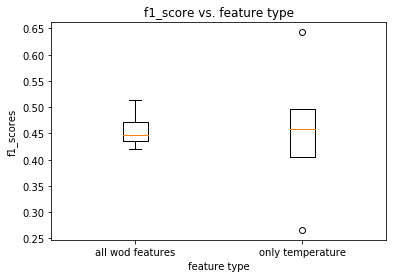

In [54]:
print('The f1 scores for the logistic regression models.  The following are the f1 scores from generating 5 models with the same regression settings, features, etc.')
plt.boxplot([f1_hurr_wod, f1_hurr_temp], labels=['all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')

plt.show()

* After adding in all the wod features into the model, the model performed on average the same.

* ### C. Add in previous year's wod data as features.

In [7]:
#add in the feature to the data and drop first row as it won't have a last year's data field
wod_last_yr = wod_yr.copy()
wod_last_yr.index = wod_last_yr.index.year
for year in range(1961,2013):
    for feature in wod_yr.columns.values:
        wod_last_yr.loc[year,str(feature)+'_last']=wod_last_yr.loc[year-1,feature]

X_last = np.array(wod_last_yr.iloc[1:,:].reset_index(drop=True))

#run logreg model
f1_hurr_last = np.empty(5) 
C_hurr_last = np.empty(5)
coeff_no = []
coeff_mild = []
coeff_sev = []
for i in range(5):
    lr_hurr_last, f1_hurr_last[i], C_hurr_last[i] = clf_mod_test(pipeline = pipeline_lr, data=X_last, target=y_hurr[1:], 
                                                              params=params_lr,rand_iters=100, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    coeffs = lr_hurr_last.best_estimator_.named_steps['logistic_regression'].coef_
    print('The model coefficients are no impact:{}, moderate:{}, severe:{}.'.format(coeffs[0],coeffs[1],coeffs[2]))
    
    print()
    coeff_no.append(coeffs[0][0])
    coeff_mild.append(coeffs[1][0])
    coeff_sev.append(coeffs[2][0])
    
print('avg f1 is {}, avg C is {}.'
      .format(np.mean(f1_hurr_last), np.mean(C_hurr_last)))

The best C value is 1034.28, with an accuracy of 0.4166666666666667.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         6
   moderate       0.36      0.57      0.44         7
     severe       0.00      0.00      0.00         3

avg / total       0.16      0.25      0.19        16


The f1 score is : 0.19444444444444442
The model coefficients are no impact:[ 1.29493904 -1.8636259   1.09373084 -3.12505266 -0.90293298 -0.30787329
  6.04875419 -1.20697855 -0.0406955   1.2458855 ], moderate:[-0.23442058  0.30429731 -0.94707537 -0.30200237  0.40344804 -0.58488903
 -3.98618205  0.61053757  0.32940467 -0.1544264 ], severe:[ -5.16790164   4.7713602   -1.14388357   2.18239024   2.41601918
   4.8919285  -11.97153927  -0.02351219  -5.11433018  -6.29888744].



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best C value is 965.3, with an accuracy of 0.5.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         5
   moderate       0.30      0.43      0.35         7
     severe       0.00      0.00      0.00         4

avg / total       0.13      0.19      0.15        16


The f1 score is : 0.15441176470588233
The model coefficients are no impact:[  6.09837268e-04  -6.61948541e-01   2.82871693e-02  -1.14092413e+01
   3.32485838e-01   7.81418343e-01   4.13357367e-01  -1.39000282e+00
   9.41055963e-01   3.43641999e-01], moderate:[ 1.74490508 -1.23041279  0.06652195 -0.28302641 -1.69109989 -1.08459599
 -1.98898365  0.69097767  0.59093697  0.26020572], severe:[ -9.90320936  11.42498616   3.52759563  15.00454676   4.45967993
  -2.06100629  -6.00708366  -7.58499791  -4.35747321   4.39864309].

The best C value is 18790.55, with an accuracy of 0.5277777777777778.

             precision    recall  f1-score   support

  no impact       0.40      

The f1 scores for the logistic regression models.  The following are the f1 scores from generating 5 models with the same regression settings, features, etc.


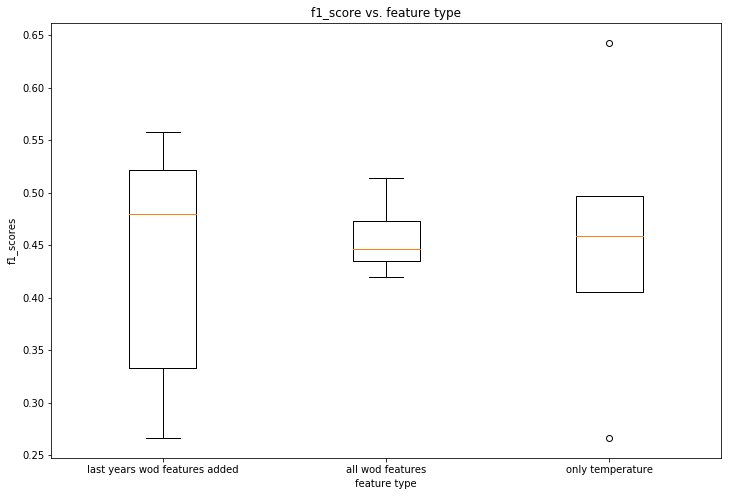

In [55]:
print('The f1 scores for the logistic regression models.  The following are the f1 scores from generating 5 models with the same regression settings, features, etc.')
plt.figure(figsize = (12,8))
plt.boxplot([f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            labels=['last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')

plt.show()

* After adding in last year's wod_features it seems that the performance on average hasn't changed once again.

* ### D. Add in the previous years number of hurricanes and average strength as features.

In [9]:
#add in the feature to the data and drop first row as it won't have a last year's data field
wod_last_yr_hurr = wod_last_yr.copy()
hurr_yr = hurr_year.copy()
hurr_yr.index = hurr_yr.index.year
hurricanes = hurr_yr.name
strengths.index = strengths.index.year

for year in range(1961,2013):
    wod_last_yr_hurr.loc[year,'last_yr_hurr']=hurricanes[year-1]
    wod_last_yr_hurr.loc[year,'last_yr_str']=strengths[year-1]

X_last_hurr = np.array(wod_last_yr_hurr.iloc[1:,:].reset_index(drop=True))

#run logreg model
f1_hurr_last_hurr = np.empty(5) 
C_hurr_last_hurr = np.empty(5)
coeff_no = []
coeff_mild = []
coeff_sev = []
for i in range(5):
    lr_hurr_last_hurr, f1_hurr_last_hurr[i], C_hurr_last_hurr[i] = clf_mod_test(pipeline = pipeline_lr, data=X_last_hurr, 
                                                                                target=y_hurr[1:], 
                                                              params=params_lr,rand_iters=100, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
    coeffs = lr_hurr_last_hurr.best_estimator_.named_steps['logistic_regression'].coef_
    print('The model coefficients are no impact:{}, moderate:{}, severe:{}.'.format(coeffs[0],coeffs[1],coeffs[2]))
    
    print()
    coeff_no.append(coeffs[0][0])
    coeff_mild.append(coeffs[1][0])
    coeff_sev.append(coeffs[2][0])
    
print('avg f1 is {}, avg C is {}.'
      .format(np.mean(f1_hurr_last_hurr), np.mean(C_hurr_last_hurr)))

The best C value is 1848.52, with an accuracy of 0.5555555555555556.

             precision    recall  f1-score   support

  no impact       0.25      0.17      0.20         6
   moderate       0.33      0.57      0.42         7
     severe       0.00      0.00      0.00         3

avg / total       0.24      0.31      0.26        16


The f1 score is : 0.2592105263157895
The model coefficients are no impact:[  6.53849397   6.38094425  -5.3984142  -39.27541944  -2.38738042
   3.19809731 -23.35883537  -1.97194567   0.59153468   2.37606714
  -6.46433383  12.08475642], moderate:[ 0.3391852   0.22664975  1.0216122  -0.4079847   0.46396455 -1.07048658
  0.35770806  0.47372934  2.77426447 -0.61356519  0.51265911 -1.55663228], severe:[-28.08650793  -3.6908792  -12.52916904  20.05694006  -3.87253517
   5.80498673  -1.24948136   1.85079803  -9.69484977  -3.75312895
   3.47076006  -5.98414329].



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best C value is 34182.54, with an accuracy of 0.5.

             precision    recall  f1-score   support

  no impact       0.60      0.50      0.55         6
   moderate       0.38      0.43      0.40         7
     severe       0.00      0.00      0.00         3

avg / total       0.39      0.38      0.38        16


The f1 score is : 0.3795454545454545
The model coefficients are no impact:[ 1.93339479 -4.41275748  0.5723138  -5.31799714  0.41062966 -1.1903383
 -1.64029837 -4.38071508 -0.30818238  0.96250497 -0.42175429  1.29617858], moderate:[ 0.6535966  -0.13492195 -0.32365176 -0.56205298 -0.59553596 -0.80735159
 -0.98679173  2.26744742  0.43459424 -1.11973449 -0.23963798 -0.75805797], severe:[-25.33494352 -23.4156618  -23.71685489  10.98120072  -5.51279168
  51.37937276 -17.95068757 -20.57312251 -10.04908234   2.74127432
   4.70297546   5.43790712].

The best C value is 14157.140000000001, with an accuracy of 0.4722222222222222.

             precision    recall  f1-score   su

The f1 scores for the logistic regression models.  The following are the f1 scores from generating 5 models with the same regression settings, features, etc.


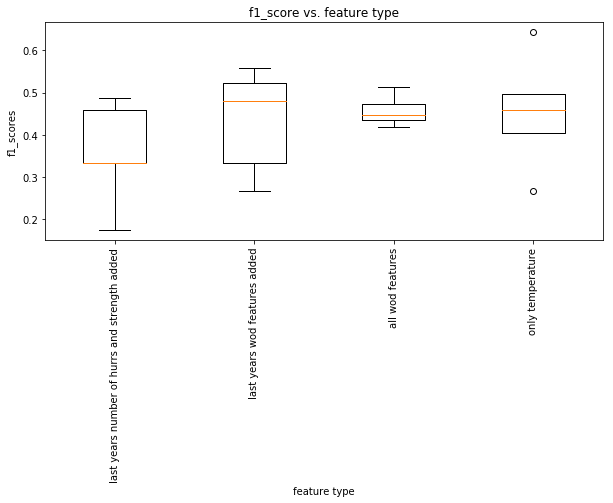

In [57]:
print('The f1 scores for the logistic regression models.  The following are the f1 scores from generating 5 models with the same regression settings, features, etc.')
plt.figure(figsize = (10,4))
plt.boxplot([f1_hurr_last_hurr,f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            labels=['last years number of hurrs and strength added','last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')
plt.xticks(rotation=90)

plt.show()

* After adding in last year's strength and number of hurricanes, the model still performs on average the same.

* ### Summary: For logistic regression for the features that I have I would choose to run with just temperature.
    * More research into features need to be done in order to create a better model and/or more data is needed.
    
### 2. SVM Classification

* ### A. Temperature only

In [24]:
from sklearn.svm import SVC

def svc_mod_test(pipeline, data, target, params, split_test_size=.3, rand_iters=10, cv_folds=3, class_labels=[]):
    """Takes a pipeline, data, targets, CV search params, test_size, 
    number of iters and number of folds for RandomizedSearchCV, and the labels of classes.
    
    Returns a tuned and fitted model and f1 weighted score and prints a classification report and f1 score."""
    
    #split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = split_test_size)

    #run grid search on pipeline
    gm_cv = RandomizedSearchCV(pipeline, param_distributions = params, cv=cv_folds, n_iter=rand_iters)
    gm_cv.fit(X_train, y_train)
    print('The best param values are {}, with an accuracy of {}.'.format(gm_cv.best_params_, gm_cv.best_score_))
    print()

    #test model on test dataset and get classification report.
    y_pred = gm_cv.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_labels))
    print()
    
    #get f1 score for model comparison
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('The f1 score is : {}'.format(f1))
    
    return gm_cv, f1

#set up pipeline
steps = [('scaler', StandardScaler())
        ,('svm', SVC())]

pipeline_svc = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_svc = {'svm__C':np.linspace(.01, 100, 10000),
              'svm__gamma':np.linspace(0.01, 100,10000)}
hurr_labels=['no impact', 'moderate', 'severe']


f1_hurr_temp = np.empty(5) 
coeff_no = []
coeff_mild = []
coeff_sev = []
for i in range(5):
    svc_hurr_temp, f1_hurr_temp[i] = svc_mod_test(pipeline = pipeline_svc, data=X[:,4].reshape(-1,1), 
                                                       target=y_hurr, params=params_svc, 
                                                       rand_iters=1000, class_labels=hurr_labels, 
                                                       split_test_size=.3, cv_folds=3)
    print('support vectors coeffs: {}'.format(svc_hurr_temp.best_estimator_.named_steps['svm'].dual_coef_))
    print()
    print('support vecotrs: {}'.format(svc_hurr_temp.best_estimator_.named_steps['svm'].support_vectors_))
    print()
print('avg f1 is {}.'
      .format(np.mean(f1_hurr_temp)))
print()

The best param values are {'svm__gamma': 0.14000000000000001, 'svm__C': 28.900000000000002}, with an accuracy of 0.6216216216216216.

             precision    recall  f1-score   support

  no impact       0.33      0.17      0.22         6
   moderate       0.50      0.75      0.60         8
     severe       0.00      0.00      0.00         2

avg / total       0.38      0.44      0.38        16


The f1 score is : 0.3833333333333333
support vectors coeffs: [[ 28.9         28.9         28.9         28.9         28.9         28.9
   18.82357554  28.9          0.         -18.2498871  -28.9        -28.9
   -0.         -28.9         -0.57368845 -28.9        -28.9        -28.9
  -28.9         -0.          -0.         -28.9        -28.9         -5.67887316
  -28.9        -28.9         -0.          -0.        ]
 [  0.          28.9         28.9         28.9          8.694648     0.
    0.           0.          25.88422515   0.           0.          18.71015074
   28.9          0.          2

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 0.34000000000000002, 'svm__C': 88.110000000000014}, with an accuracy of 0.6756756756756757.

             precision    recall  f1-score   support

  no impact       0.33      0.20      0.25         5
   moderate       0.46      0.75      0.57         8
     severe       0.00      0.00      0.00         3

avg / total       0.33      0.44      0.36        16


The f1 score is : 0.3638392857142857
support vectors coeffs: [[ 88.11         0.           4.7850505   88.11        29.53120338  88.11
   15.18018002  88.11        88.11        88.11        88.11        -0.
  -88.11       -88.11       -88.11        -0.          -0.         -88.11
  -30.33997822 -88.11       -19.15645569 -88.11       -88.11       -88.11
   -0.         -88.11       -88.11        -0.          -0.        ]
 [  0.          48.09717483   5.27038263  88.11        34.74244254  88.11
    0.           0.           0.           0.           0.          88.11
   38.76380841  37.9533782

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 1.3200000000000001, 'svm__C': 43.439999999999998}, with an accuracy of 0.6756756756756757.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         7
   moderate       0.45      0.71      0.56         7
     severe       0.00      0.00      0.00         2

avg / total       0.20      0.31      0.24        16


The f1 score is : 0.24305555555555558
support vectors coeffs: [[  1.46780628  43.44        43.44        43.44        43.44        43.44
   43.44        43.44         2.36018065 -43.44       -12.13316152
  -14.37811459  -3.82409318  -0.          -0.         -38.82704151 -43.44
  -15.68947615 -43.44       -34.98332755 -43.44       -14.31277242
   -1.48413369  -4.54536824  -0.         -13.24110622 -43.44       -43.44      ]
 [  1.06463358   3.00905237  16.05211217   0.          43.44         8.7542332
   21.70131818   0.          12.12925865   0.           0.          43.44
    1.66522782  36.0

* ### B. All wod features

In [25]:
f1_hurr_wod = np.empty(5) 
for i in range(5):
    svc_hurr_wod, f1_hurr_wod[i] = svc_mod_test(pipeline = pipeline_svc, data=X, target=y_hurr, 
                                                              params=params_svc,rand_iters=1000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
    print('support vectors coeffs: {}'.format(svc_hurr_wod.best_estimator_.named_steps['svm'].dual_coef_))
    print()
    print('support vecotrs: {}'.format(svc_hurr_wod.best_estimator_.named_steps['svm'].support_vectors_))
    print()
print('avg f1 is {}.'
      .format(np.mean(f1_hurr_wod)))
print()

The best param values are {'svm__gamma': 49.829999999999998, 'svm__C': 41.25}, with an accuracy of 0.4594594594594595.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         4
   moderate       0.62      1.00      0.77        10
     severe       0.00      0.00      0.00         2

avg / total       0.39      0.62      0.48        16


The f1 score is : 0.4807692307692308
support vectors coeffs: [[  1.1573534   41.25         1.17944658   1.16592182   1.14154437
    1.14158242   1.01435699   1.15254597   1.14978108   1.36719102
    1.10482642   1.14139844   0.96468281  -0.95731963  -0.85820527
   -0.77641599  -0.93366661  -0.85841747  -0.85845477  -0.72305661 -41.25
   -0.89091801  -0.87914946  -0.91473136  -0.85758796  -0.86236401
   -0.72259429  -0.85841758  -0.87086768  -0.85846465  -1.28822753
   -1.28789754  -1.28822753  -1.28738563  -1.28738563  -1.28774924
   -1.28753451]
 [  0.71210288   0.71225515   0.71141577   0.71210246   0.

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 36.57, 'svm__C': 0.47000000000000003}, with an accuracy of 0.43243243243243246.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         5
   moderate       0.69      1.00      0.81        11

avg / total       0.47      0.69      0.56        16


The f1 score is : 0.5601851851851851
support vectors coeffs: [[ 0.47        0.47        0.47        0.47        0.47        0.47        0.47
   0.47        0.47        0.47        0.47        0.47       -0.36635714
  -0.40725608 -0.27073214 -0.36635971 -0.36797913 -0.22904186 -0.47
  -0.3663062  -0.43870923 -0.36644657 -0.16939077 -0.36630662 -0.31982723
  -0.37368682 -0.3883152  -0.3732853  -0.47       -0.47       -0.47       -0.47
  -0.47       -0.47       -0.47       -0.47       -0.47      ]
 [ 0.35348204  0.35409656  0.35379556  0.35383551  0.35376632  0.3434561
   0.35430824  0.34480367  0.35779742  0.35430824  0.35457993  0.3517704
   0.29561733  0

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 3
  .format(len(labels), len(target_names))
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 83.580000000000013, 'svm__C': 0.37}, with an accuracy of 0.5405405405405406.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         7
   moderate       0.44      1.00      0.61         7
     severe       0.00      0.00      0.00         2

avg / total       0.19      0.44      0.27        16


The f1 score is : 0.266304347826087
support vectors coeffs: [[ 0.37        0.37        0.37        0.37        0.37        0.37        0.37
   0.37        0.37        0.37       -0.18155222 -0.13400442 -0.18106967
  -0.18121811 -0.16866249 -0.18190178 -0.18067854 -0.37       -0.18123049
  -0.1874636  -0.18068069 -0.18155265 -0.18122356 -0.17663517 -0.18182961
  -0.18186653 -0.18105964 -0.17239077 -0.18124178 -0.13373827 -0.37       -0.37
  -0.37       -0.37       -0.37       -0.37       -0.37      ]
 [ 0.25969621  0.25901556  0.25901583  0.25969621  0.25953664  0.25764698
   0.25902407  0.25901904  0.2596

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 19.500000000000004, 'svm__C': 54.089999999999996}, with an accuracy of 0.5675675675675675.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         6
   moderate       0.47      0.88      0.61         8
     severe       0.00      0.00      0.00         2

avg / total       0.23      0.44      0.30        16


The f1 score is : 0.3043478260869565
support vectors coeffs: [[  1.17085057   1.29716108   1.29583381   1.29576441   1.53485804
    0.61461645  54.08858393   1.32716492   1.29626239   1.56009343
    1.37803808  -1.26507742  -0.89213406  -0.714878    -0.56891232
   -0.05819575  -0.70377213  -0.70425941  -0.83712288  -0.83108118
   -0.60467301 -54.09        -0.70421333  -0.72318169  -0.23726402
   -0.66886437  -0.70394931  -1.05229711  -0.79522854  -0.70412255
   -1.11820042  -1.11828643  -1.11800879  -1.11847877  -1.11824767
   -1.11832383  -1.11870977]
 [  0.55883188   0.           0.8817323

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 49.850000000000001, 'svm__C': 0.15000000000000002}, with an accuracy of 0.4594594594594595.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         3
   moderate       0.62      1.00      0.77        10
     severe       0.00      0.00      0.00         3

avg / total       0.39      0.62      0.48        16


The f1 score is : 0.4807692307692308
support vectors coeffs: [[ 0.15        0.15        0.15        0.15        0.15        0.15        0.15
   0.15        0.15        0.15        0.15        0.15        0.15        0.15
  -0.12099366 -0.1222438  -0.08566886 -0.14648461 -0.12298483 -0.1232561
  -0.12405477 -0.12593475 -0.12264773 -0.15       -0.12638241 -0.15
  -0.123473   -0.07752073 -0.13458782 -0.12278068 -0.12098624 -0.15       -0.15
  -0.15       -0.15       -0.15       -0.15      ]
 [ 0.06497316  0.06563764  0.06511906  0.0655757   0.06556262  0.06555636
   0.06510479  0.06509632  0.0

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 scores for the svm classification models.  The following are the f1 scores from generating 5 models with the same svm settings, features, etc.


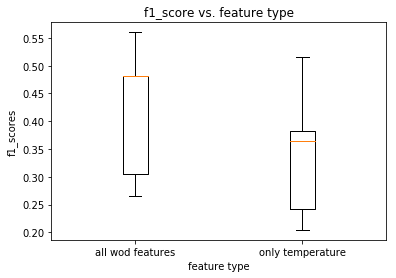

In [26]:
print('The f1 scores for the svm classification models.  The following are the f1 scores from generating 5 models with the same svm settings, features, etc.')
plt.boxplot([f1_hurr_wod, f1_hurr_temp], labels=['all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')

plt.show()

* After adding in all the wod features into the model, the model performed on average the same or a little better.
* Moreover, the performance is very similar to the logistic regression performance or a worse.

* ### C. Add in previous year's wod data as features.

In [31]:
f1_hurr_last = np.empty(5) 
for i in range(5):
    svc_hurr_last, f1_hurr_last[i] = svc_mod_test(pipeline = pipeline_svc, data=X_last, target=y_hurr[1:], 
                                                              params=params_svc,rand_iters=1000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
    print('support vectors coeffs: {}'.format(svc_hurr_last.best_estimator_.named_steps['svm'].dual_coef_))
    print()
    print('support vecotrs: {}'.format(svc_hurr_last.best_estimator_.named_steps['svm'].support_vectors_))
    print()
print('avg f1 is {}.'
      .format(np.mean(f1_hurr_last)))
print()

The best param values are {'svm__gamma': 94.77000000000001, 'svm__C': 0.56000000000000005}, with an accuracy of 0.4722222222222222.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         6
   moderate       0.56      1.00      0.72         9
     severe       0.00      0.00      0.00         1

avg / total       0.32      0.56      0.40        16


The f1 score is : 0.40499999999999997
support vectors coeffs: [[ 0.56        0.56        0.56        0.56        0.56        0.56        0.56
   0.56        0.56        0.56        0.56       -0.35       -0.35000017
  -0.35000008 -0.34999955 -0.34999987 -0.35000004 -0.35000002 -0.35000017
  -0.3500001  -0.56       -0.35000005 -0.35       -0.35000004 -0.34999998
  -0.35       -0.35       -0.34999992 -0.56       -0.56       -0.56       -0.56
  -0.56       -0.56       -0.56       -0.56      ]
 [ 0.406875    0.40742188  0.406875    0.406875    0.40742188  0.40742188
   0.40742188  0.40742188  0.

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 36.339999999999996, 'svm__C': 0.099999999999999992}, with an accuracy of 0.5.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         6
   moderate       0.50      1.00      0.67         8
     severe       0.00      0.00      0.00         2

avg / total       0.25      0.50      0.33        16


The f1 score is : 0.3333333333333333
support vectors coeffs: [[ 0.1         0.1         0.1         0.1         0.1         0.1         0.1
   0.1         0.1         0.1         0.1        -0.05859375 -0.05859375
  -0.05859375 -0.05937503 -0.05859375 -0.05859375 -0.1        -0.05859375
  -0.05859375 -0.059375   -0.05859375 -0.05859375 -0.05859375 -0.059375
  -0.05859375 -0.059375   -0.05859375 -0.059375   -0.1        -0.1        -0.1
  -0.1        -0.1        -0.1        -0.1       ]
 [ 0.0640625   0.0640625   0.0640625   0.06328125  0.0640625   0.06328125
   0.06328125  0.06328125  0.06328125  0.063281

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 57.859999999999999, 'svm__C': 0.35000000000000003}, with an accuracy of 0.5.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         7
   moderate       0.50      1.00      0.67         8
     severe       0.00      0.00      0.00         1

avg / total       0.25      0.50      0.33        16


The f1 score is : 0.3333333333333333
support vectors coeffs: [[ 0.35        0.35        0.35        0.35        0.35        0.35        0.35
   0.35        0.35        0.35       -0.18598702 -0.18525531 -0.18525498
  -0.18525523 -0.35       -0.1852552  -0.18525568 -0.18525523 -0.18524012
  -0.18522532 -0.18522575 -0.1852552  -0.18525568 -0.18525651 -0.18525569
  -0.18525569 -0.18525569 -0.18525569 -0.35       -0.35       -0.35       -0.35
  -0.35       -0.35       -0.35       -0.35      ]
 [ 0.27958984  0.28027344  0.28027344  0.27958984  0.28027344  0.28027344
   0.28027344  0.28027344  0.27958984  0.279

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 0.14000000000000001, 'svm__C': 7.7299999999999995}, with an accuracy of 0.5555555555555556.

             precision    recall  f1-score   support

  no impact       0.40      0.50      0.44         4
   moderate       0.60      0.67      0.63         9
     severe       0.00      0.00      0.00         3

avg / total       0.44      0.50      0.47        16


The f1 score is : 0.46637426900584794
support vectors coeffs: [[ 4.66920229  1.69121279  0.18179118  7.73        0.7163148   7.73        7.73
   7.73        3.68376379  0.21279121  0.23664786  6.83437144  3.91685622
  -7.27602534 -6.29704196 -2.69260861 -7.73       -7.73       -1.81237771
  -0.         -5.38054956 -7.73       -2.05822457 -4.35612385 -1.0412212
  -7.73       -0.         -1.01666795 -1.05569333 -4.42930238]
 [ 0.          0.          0.          5.62833606  2.19917317  0.
   4.95651444  0.          0.          0.95806549  0.99825004  0.53254567
   0.          0.          0.  

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 scores for the logistic regression models.  The following are the f1 scores from generating 5 models with the same regression settings, features, etc.


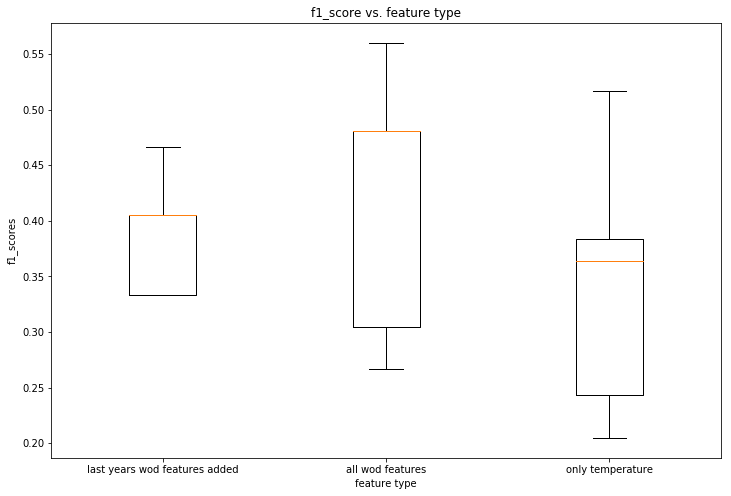

In [32]:
print('The f1 scores for the svm classification models.  The following are the f1 scores from generating 5 models with the same svm settings, features, etc.')
plt.figure(figsize = (12,8))
plt.boxplot([f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            labels=['last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')

plt.show()

* After adding in last year's wod_features it seems that the performance has gotten slightly worse.
* Also, the performance to the logistic regression model is similar or worse.

* ### D. Add in the previous years number of hurricanes and average strength as features.

In [33]:
f1_hurr_last_hurr = np.empty(5) 
for i in range(5):
    svc_hurr_last_hurr, f1_hurr_last_hurr[i] = svc_mod_test(pipeline = pipeline_svc, data=X_last_hurr, target=y_hurr[1:], 
                                                              params=params_svc,rand_iters=1000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
    print('support vectors coeffs: {}'.format(svc_hurr_last_hurr.best_estimator_.named_steps['svm'].dual_coef_))
    print()
    print('support vecotrs: {}'.format(svc_hurr_last_hurr.best_estimator_.named_steps['svm'].support_vectors_))
    print()
print('avg f1 is {}.'
      .format(np.mean(f1_hurr_last_hurr)))
print()

The best param values are {'svm__gamma': 99.230000000000004, 'svm__C': 0.47000000000000003}, with an accuracy of 0.4444444444444444.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         4
   moderate       0.62      1.00      0.77        10
     severe       0.00      0.00      0.00         2

avg / total       0.39      0.62      0.48        16


The f1 score is : 0.4807692307692308
support vectors coeffs: [[ 0.47        0.47        0.47        0.47        0.47        0.47        0.47
   0.47        0.47        0.47        0.47        0.47        0.47
  -0.37544922 -0.37544922 -0.37544922 -0.37636719 -0.37636719 -0.37636719
  -0.37636719 -0.37636719 -0.37636719 -0.37544922 -0.37544922 -0.47
  -0.37544922 -0.37636719 -0.37636719 -0.37636719 -0.47       -0.47       -0.47
  -0.47       -0.47       -0.47       -0.47      ]
 [ 0.25244141  0.25335937  0.25335937  0.25335937  0.25335937  0.25335937
   0.25335938  0.25335938  0.25335937  0.

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 21.920000000000002, 'svm__C': 38.009999999999998}, with an accuracy of 0.6388888888888888.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00        10
   moderate       0.19      1.00      0.32         3
     severe       0.00      0.00      0.00         3

avg / total       0.04      0.19      0.06        16


The f1 score is : 0.05921052631578947
support vectors coeffs: [[ 1.53320306  1.53320307  1.53320307  1.53320307  1.53320306  1.53320307
   1.53320307 -0.46582041 -0.46679693 -0.46679694 -0.46679694 -0.46679694
  -0.46581953 -0.46582041 -0.46679693 -0.46679693 -0.46679693 -0.46582028
  -0.4667968  -0.46679694 -0.46679693 -0.46679693 -0.46679607 -0.46679693
  -0.46679693 -0.46679694 -0.46679694 -0.46679694 -0.46679694 -0.46679694
  -1.07617188 -1.07714844 -1.07714844 -1.07714844 -1.07714844 -1.07714844]
 [ 0.92285156  0.92382812  0.92285156  0.92285156  0.92285156  0.92285156
   0.92382812  0.

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 55.810000000000002, 'svm__C': 94.390000000000001}, with an accuracy of 0.5277777777777778.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         5
   moderate       0.44      1.00      0.61         7
     severe       0.00      0.00      0.00         4

avg / total       0.19      0.44      0.27        16


The f1 score is : 0.266304347826087
support vectors coeffs: [[ 1.2265625   1.2265625   1.2265625   1.2265625   1.2265625   1.2265625
   1.2265625   1.22558594  1.22558594  1.22558594  1.22558594  1.22558594
  -0.77441406 -0.77441406 -0.77441406 -0.77441406 -0.77441406 -0.77441406
  -0.77441406 -0.77441406 -0.77441406 -0.77441406 -0.77441406 -0.77441406
  -0.77441406 -0.77441406 -0.77441406 -0.77441406 -0.77441406 -0.77441406
  -0.77441406 -1.41210938 -1.41210938 -1.41113281 -1.41113281 -1.41113281]
 [ 0.58789062  0.58789062  0.58789062  0.58886719  0.58886719  0.58886719
   0.58789062  0.587

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'svm__gamma': 0.080000000000000002, 'svm__C': 11.99}, with an accuracy of 0.6111111111111112.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         5
   moderate       0.45      0.71      0.56         7
     severe       0.00      0.00      0.00         4

avg / total       0.20      0.31      0.24        16


The f1 score is : 0.24305555555555558
support vectors coeffs: [[  0.48929976  11.99         9.17392548   7.166812     3.21503107
    4.05139734   2.8074244    0.62858579   3.98774984   0.86734257
   -1.49198032  -0.27230084 -11.99        -1.71653423 -10.37103672
   -1.45483207  -0.16568607 -11.99        -1.89175638  -0.          -0.60269128
   -0.80070615  -1.41668256  -0.21336165  -3.85546296  -2.11454871
   -3.94330229  -0.83608369  -6.80381832]
 [  0.68906783   6.36566888   0.           0.           0.           0.
    2.85956191   0.86593308   6.21461381   0.55837046   2.04816514  11.99
    0.     

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 scores for the svm classification models.  The following are the f1 scores from generating 5 models with the same svm settings, features, etc.


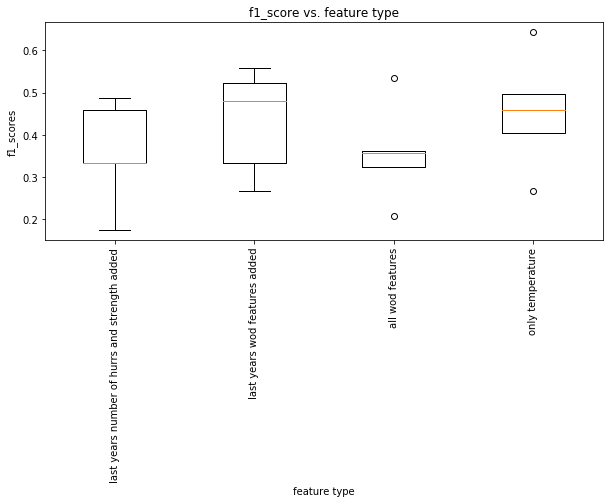

In [52]:
print('The f1 scores for the svm classification models.  The following are the f1 scores from generating 5 models with the same svm settings, features, etc.')
plt.figure(figsize = (10,4))
plt.boxplot([f1_hurr_last_hurr,f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            labels=['last years number of hurrs and strength added','last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')
plt.xticks(rotation=90)

plt.show()

* After adding in last year's strength and number of hurricanes, the model still performs on average the same or worse.

* ### Summary: For svm classification for the features that I have I would choose to run with all wod features.
    * More research into features need to be done in order to create a better model and/or more data is needed.
    * Also the model performed on average worse than logistic regression.

### 3. k Nearest Neighbors

* ### A. Temperature only

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def knn_mod_test(pipeline, data, target, params, split_test_size=.3, cv_folds=3, class_labels=[]):
    """Takes a pipeline, data, targets, CV search params, test_size, 
    number of folds for GridSearchCV, and the labels of classes.
    
    Returns a tuned and fitted model and f1 weighted score and prints a classification report and f1 score."""
    
    #split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = split_test_size)

    #run grid search on pipeline
    gm_cv = GridSearchCV(pipeline, param_grid = params, cv=cv_folds)
    gm_cv.fit(X_train, y_train)
    print('The best param values are {}, with an accuracy of {}.'.format(gm_cv.best_params_, gm_cv.best_score_))
    print()

    #test model on test dataset and get classification report.
    y_pred = gm_cv.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_labels))
    print()
    
    #get f1 score for model comparison
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('The f1 score is : {}'.format(f1))
    
    return gm_cv, f1

#set up pipeline
steps = [('scaler', StandardScaler())
        ,('knn', KNeighborsClassifier())]

pipeline_knn = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_knn = {'knn__n_neighbors':np.arange(1, 20, 1)}
hurr_labels=['no impact', 'moderate', 'severe']


f1_hurr_temp = np.empty(5) 

for i in range(5):
    knn_hurr_temp, f1_hurr_temp[i] = knn_mod_test(pipeline = pipeline_knn, data=X[:,4].reshape(-1,1), 
                                                       target=y_hurr, params=params_knn, class_labels=hurr_labels, 
                                                       split_test_size=.3, cv_folds=3)
    
print('avg f1 is {}.'
      .format(np.mean(f1_hurr_temp)))
print()

The best param values are {'knn__n_neighbors': 8}, with an accuracy of 0.6756756756756757.

             precision    recall  f1-score   support

  no impact       0.40      0.50      0.44         4
   moderate       0.36      0.57      0.44         7
     severe       0.00      0.00      0.00         5

avg / total       0.26      0.38      0.31        16


The f1 score is : 0.3055555555555555
The best param values are {'knn__n_neighbors': 12}, with an accuracy of 0.5135135135135135.

             precision    recall  f1-score   support

  no impact       0.75      0.60      0.67         5
   moderate       0.75      0.90      0.82        10
     severe       0.00      0.00      0.00         1

avg / total       0.70      0.75      0.72        16


The f1 score is : 0.7196969696969696


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 13}, with an accuracy of 0.5405405405405406.

             precision    recall  f1-score   support

  no impact       0.80      0.80      0.80         5
   moderate       0.64      0.88      0.74         8
     severe       0.00      0.00      0.00         3

avg / total       0.57      0.69      0.62        16


The f1 score is : 0.618421052631579
The best param values are {'knn__n_neighbors': 9}, with an accuracy of 0.5135135135135135.

             precision    recall  f1-score   support

  no impact       1.00      0.40      0.57         5
   moderate       0.64      1.00      0.78         9
     severe       0.00      0.00      0.00         2

avg / total       0.67      0.69      0.62        16


The f1 score is : 0.6187888198757765


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 3}, with an accuracy of 0.5135135135135135.

             precision    recall  f1-score   support

  no impact       0.29      0.40      0.33         5
   moderate       0.62      0.62      0.62         8
     severe       1.00      0.33      0.50         3

avg / total       0.59      0.50      0.51        16


The f1 score is : 0.5104166666666666
avg f1 is 0.5545758128853093.



* ### B. All wod features

In [43]:
f1_hurr_wod = np.empty(5) 
for i in range(5):
    knn_hurr_wod, f1_hurr_wod[i] = knn_mod_test(pipeline = pipeline_knn, data=X, target=y_hurr, 
                                                              params=params_knn, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
    
print('avg f1 is {}.'
      .format(np.mean(f1_hurr_wod)))
print()

The best param values are {'knn__n_neighbors': 9}, with an accuracy of 0.5135135135135135.

             precision    recall  f1-score   support

  no impact       0.60      0.43      0.50         7
   moderate       0.55      0.75      0.63         8
     severe       0.00      0.00      0.00         1

avg / total       0.54      0.56      0.53        16


The f1 score is : 0.5345394736842105


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 4}, with an accuracy of 0.5675675675675675.

             precision    recall  f1-score   support

  no impact       0.30      0.75      0.43         4
   moderate       0.60      0.30      0.40        10
     severe       0.00      0.00      0.00         2

avg / total       0.45      0.38      0.36        16


The f1 score is : 0.3571428571428571
The best param values are {'knn__n_neighbors': 10}, with an accuracy of 0.5945945945945946.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         6
   moderate       0.36      0.71      0.48         7
     severe       0.00      0.00      0.00         3

avg / total       0.16      0.31      0.21        16


The f1 score is : 0.20833333333333334


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 8}, with an accuracy of 0.5405405405405406.

             precision    recall  f1-score   support

  no impact       0.17      0.25      0.20         4
   moderate       0.50      0.50      0.50        10
     severe       0.00      0.00      0.00         2

avg / total       0.35      0.38      0.36        16


The f1 score is : 0.3625


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 9}, with an accuracy of 0.6216216216216216.

             precision    recall  f1-score   support

  no impact       1.00      0.14      0.25         7
   moderate       0.40      1.00      0.57         6
     severe       0.00      0.00      0.00         3

avg / total       0.59      0.44      0.32        16


The f1 score is : 0.3236607142857143
avg f1 is 0.35723527568922303.



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 scores for the knn classification models.  The following are the f1 scores from generating 5 models with the same knn settings, features, etc.


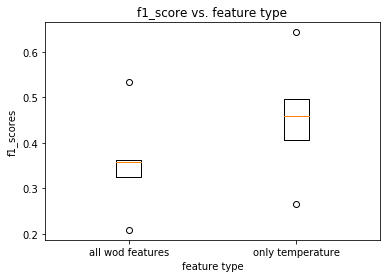

In [44]:
print('The f1 scores for the knn classification models.  The following are the f1 scores from generating 5 models with the same knn settings, features, etc.')
plt.boxplot([f1_hurr_wod, f1_hurr_temp], labels=['all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')

plt.show()

* After adding in all the wod features into the model, the model performed on average the same or a little worse.
* Moreover, the performance is very similar to the logistic regression and svm classification performance.

* ### C. Add in previous year's wod data as features.

In [45]:
f1_hurr_last = np.empty(5) 
for i in range(5):
    knn_hurr_last, f1_hurr_last[i] = knn_mod_test(pipeline = pipeline_knn, data=X_last, target=y_hurr[1:], 
                                                              params=params_knn, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
    
print('avg f1 is {}.'
      .format(np.mean(f1_hurr_last)))
print()

The best param values are {'knn__n_neighbors': 16}, with an accuracy of 0.5555555555555556.

             precision    recall  f1-score   support

  no impact       1.00      0.25      0.40         4
   moderate       0.60      1.00      0.75         9
     severe       0.00      0.00      0.00         3

avg / total       0.59      0.62      0.52        16


The f1 score is : 0.521875


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 9}, with an accuracy of 0.5833333333333334.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         2
   moderate       0.54      0.88      0.67         8
     severe       0.00      0.00      0.00         6

avg / total       0.27      0.44      0.33        16


The f1 score is : 0.33333333333333337


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 6}, with an accuracy of 0.5277777777777778.

             precision    recall  f1-score   support

  no impact       0.50      0.20      0.29         5
   moderate       0.64      0.90      0.75        10
     severe       0.00      0.00      0.00         1

avg / total       0.56      0.62      0.56        16


The f1 score is : 0.5580357142857143


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 10}, with an accuracy of 0.5833333333333334.

             precision    recall  f1-score   support

  no impact       0.40      0.50      0.44         4
   moderate       0.64      0.88      0.74         8
     severe       0.00      0.00      0.00         4

avg / total       0.42      0.56      0.48        16


The f1 score is : 0.47953216374269003
The best param values are {'knn__n_neighbors': 4}, with an accuracy of 0.5833333333333334.

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




             precision    recall  f1-score   support

  no impact       0.27      0.75      0.40         4
   moderate       0.50      0.25      0.33         8
     severe       0.00      0.00      0.00         4

avg / total       0.32      0.31      0.27        16


The f1 score is : 0.26666666666666666
avg f1 is 0.43188857560568084.



The f1 scores for the knn classification models.  The following are the f1 scores from generating 5 models with the same knn settings, features, etc.


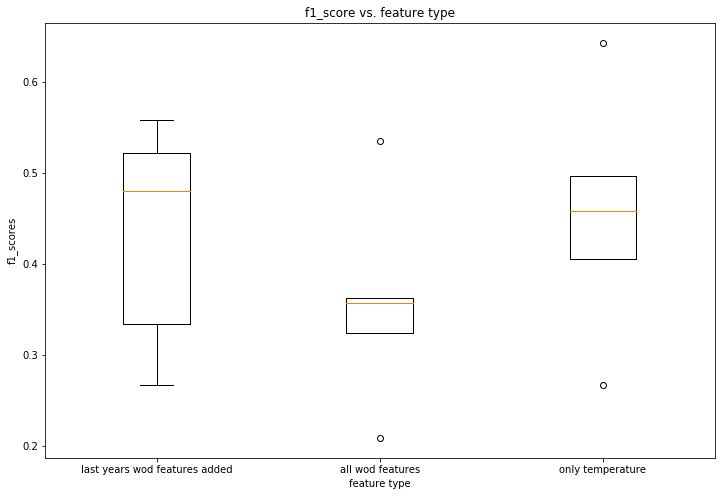

In [48]:
print('The f1 scores for the knn classification models.  The following are the f1 scores from generating 5 models with the same knn settings, features, etc.')
plt.figure(figsize = (12,8))
plt.boxplot([f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            labels=['last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')

plt.show()

* After adding in last year's wod features it seems that the performance on average hasn't changed once again from temp only.
* Also, the performance to the logistic regression model and svm classification model is similar or worse.

* ### D. Add in the previous years number of hurricanes and average strength as features.

In [46]:
f1_hurr_last_hurr = np.empty(5) 
for i in range(5):
    knn_hurr_last_hurr, f1_hurr_last_hurr[i] = knn_mod_test(pipeline = pipeline_knn, data=X_last_hurr, target=y_hurr[1:], 
                                                              params=params_knn, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
    
print('avg f1 is {}.'
      .format(np.mean(f1_hurr_last_hurr)))
print()

The best param values are {'knn__n_neighbors': 6}, with an accuracy of 0.5.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         6
   moderate       0.50      1.00      0.67         8
     severe       0.00      0.00      0.00         2

avg / total       0.25      0.50      0.33        16


The f1 score is : 0.3333333333333333


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best param values are {'knn__n_neighbors': 13}, with an accuracy of 0.6111111111111112.

             precision    recall  f1-score   support

  no impact       0.25      0.25      0.25         4
   moderate       0.58      0.70      0.64        10
     severe       0.00      0.00      0.00         2

avg / total       0.43      0.50      0.46        16


The f1 score is : 0.4602272727272728
The best param values are {'knn__n_neighbors': 12}, with an accuracy of 0.5.

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\s



             precision    recall  f1-score   support

  no impact       0.33      0.20      0.25         5
   moderate       0.62      0.89      0.73         9
     severe       0.00      0.00      0.00         2

avg / total       0.45      0.56      0.49        16


The f1 score is : 0.48721590909090917
The best param values are {'knn__n_neighbors': 17}, with an accuracy of 0.5277777777777778.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         4
   moderate       0.50      1.00      0.67         8
     severe       0.00      0.00      0.00         4

avg / total       0.25      0.50      0.33        16


The f1 score is : 0.3333333333333333
The best param values are {'knn__n_neighbors': 10}, with an accuracy of 0.5833333333333334.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         5
   moderate       0.31      0.57      0.40         7
     severe       0.00      0.00      0

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 scores for the knn classification models.  The following are the f1 scores from generating 5 models with the same knn settings, features, etc.


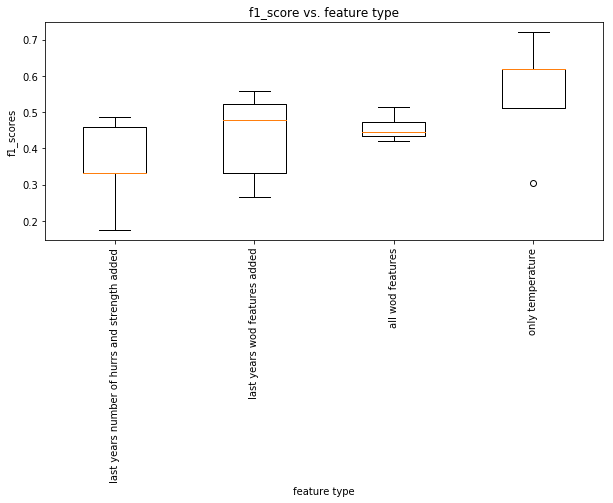

In [64]:
print('The f1 scores for the knn classification models.  The following are the f1 scores from generating 5 models with the same knn settings, features, etc.')
plt.figure(figsize = (10,4))
plt.boxplot([f1_hurr_last_hurr,f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            labels=['last years number of hurrs and strength added','last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')
plt.xticks(rotation=90)

plt.show()

* After adding in last year's strength and number of hurricanes, the model still performs on average the same or worse.

* ### Summary: For knn classification for the features that I have I would choose to run with temp only.
    * More research into features need to be done in order to create a better model and/or more data is needed.
    * Also the model performed on average the same or worse than logistic regression, and better than svm classification.
    
***

## Summary
* As of right now the best performing model is the logistic regression with only temperature as the sole feature in the model.
    * Average f1 score of 0.45.
* There are too few data points and not enough statistically significant features to use in the models.
* In order to improve the various models, more research into features needs to be done, and more data collected.
    * However, the only way to collect more data is by waiting and recording.
    * Other features could be global weather trends for the year such as off the coast of africas where hurricanes start or the north atlantic current, etc.
    * Here are the ones used by NOAA to predict hurricane activity but not landfall.
        1. The conducive conditions which were predicted in May for the Atlantic hurricane Main Development Region (MDR, which includes the tropical Atlantic and Caribbean Sea) are now present and are expected to persist through the peak months (August-October, ASO) of the hurricane season. These conditions include weaker vertical wind shear, weaker trade winds, more conducive wind patterns coming off of Africa, and a stronger west African monsoon.

        2. There is much higher confidence that ENSO-neutral conditions will persist through ASO, and that El Niño will not develop and suppress the season. 

        3. Warmer sea surface temperatures (SSTs) in the MDR are more likely to persist than key models had previously predicted.

        4. All models now predict a more active season than they did in May.

        5. Enhanced June-July activity in the tropical Atlantic (tropical storms Bret and Don) reinforces the expectation for an above-normal season. Historically, years with early-season activity in this region have a higher likelihood of being above-normal.
        
# This is where future analysis and modeling of category strength could be done.